<a href="https://colab.research.google.com/github/vgentile98/zebraproject/blob/main/Zebra_Group_Project_V2_(latest).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Zebra Project 🦓</b></h1>

<a href="https://colab.research.google.com/drive/1qCTnIY36rMGk_oIEAksNluO8WJ-Ppfed?usp=sharing" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




#Resources


*   <b>GitHub Repository</b>: https://github.com/vgentile98/zebraproject
*   <b>Google Doc:</b> https://docs.google.com/document/d/11Q1ynH7498Pkmoe1UQTVuvr8zzTAIlCpE_L2xu3RpdE/edit
*   <b>Canva Presentation:</b> https://www.canva.com/design/DAFxCBko9SI/-m-ZGnVbyZqNDBfezkHZ4g/edit
*   <b>World Bank:</b> https://pypi.org/project/wbgapi/



#Libraries Import 📚

In [3]:
pip install wbgapi

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import wbgapi as wb
import shapefile as shp
import itertools

from scipy.stats import skew, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


<h2> Variables Selection</h2>




*   **Dependent variable**: Environmental Policy Stringency Index
    *   The index measures the degree to which environmental policies put an explicit or implicit price on polluting or environmentally harmful behaviour. The index ranges from 0 (not stringent) to 6 (highest degree of stringency) and is based on the degree of stringency of 14 environmental policy instruments, both market-based and non-market-based, primarily related to climate and air pollution. These policy instruments include environmental taxes on SOx, NOx, diesel, and CO2; trading schemes in CO2; renewable energy and energy efficiency certificates; feed-in tariffs on solar and wind energy; deposit and refund schemes; emission limit values on NOx, SOx, PMx and sulphur content limits in diesel, as well as government expenditure on research and development within renewable energy.
    *   https://www.qogdata.pol.gu.se/data/codebook_ei_sept21_august2023.pdf

*   **Independent variable**: Proportion of seats held by women in national parliaments (%)
    *   https://databank.worldbank.org/source/gender-statistics
*   **Control variables**: GDP, Education level, Political ideology, Environmental activism
*   **Heterogeneity variables**: Fertility rate
    * Total fertility rate represents the number of children that would be born to a woman if she were to live to the end of her childbearing years and bear children in accordance with age-specific fertility rates of the specified year.


#Sample Selection 🥢




##<h3>1) World Bank Group (WBG)</h3>


### <h4>1.1) Gender Statistics Dataset</h4>
Getting the <b>percentage of seats held by women in national parliaments</b> and the <b>fertility rate</b>.

In [94]:
# Fetching dataset 14 (Gender Statistics)
wb.db = 14

In [95]:
# Fetch data on proportion of seats held by women in national parliaments
df_wbg_women_seats = wb.data.DataFrame(['SG.GEN.PARL.ZS'], labels=True).reset_index()

In [96]:
# Fetching data on fertility rate
df_wbg_fertility_rate = wb.data.DataFrame(['SP.DYN.TFRT.IN'], labels=True).reset_index()

### <h4>1.2) World Development Indicators Dataset</h4>
Getting the <b>GDP per capita (constant LCU)</b>, <b>trade openness</b>, and <b>CO2 emissions per capita</b>.

In [97]:
# Fetching dataset 2 (World Development Indicators)
wb.db = 2

In [98]:
# Fetch data on gdp per capita
df_wbg_gdp = wb.data.DataFrame(['NY.GDP.PCAP.KN'], labels=True).reset_index()

In [99]:
# Fetch data on trade openness
df_wbg_openness = wb.data.DataFrame(['NE.TRD.GNFS.ZS'], labels=True).reset_index()

In [100]:
# Fetch data on CO2 emissions per capita
df_wbg_co2 = wb.data.DataFrame(['EN.ATM.CO2E.PC'], labels=True).reset_index()

### <h4>1.3) Education Statistics Dataset</h4>
Getting the <b>years of education</b>.

In [101]:
# Fetching dataset 12 (Education Statistics)
wb.db = 12

In [102]:
# Fetch data on years of education of total population of 15+ years old
df_wbg_education = wb.data.DataFrame(['BAR.SCHL.15UP.FE'], labels=True).reset_index()

/usr/local/lib/python3.10/dist-packages/wbgapi/data.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index_key, column_key] = np.nan if row['value'] is None else row['value']


### <h4>1.4) Merging Datasets from WBG</h4>

In [103]:
# Defining a function for rearranging WBG datasets
def rearrange(df, value_name):
    # Reshape dataframes to have the year as a separate column
    df = df.melt(id_vars=["economy", "Country"], var_name="year", value_name=value_name)
    # Extract the year column and make sure its type is integer
    df['year'] = df['year'].astype(str).str.extract('(\d+)').astype(int)
    df = df.rename(columns={'economy': 'country_code', 'Country': 'country_name'})
    return df

In [104]:
# Rearranging dataframes
df_wbg_women_seats_melted = rearrange(df_wbg_women_seats, "women_seats")
df_wbg_fertility_rate_melted = rearrange(df_wbg_fertility_rate, "fertility_rate")
df_wbg_gdp_melted = rearrange(df_wbg_gdp, "gdp")
df_wbg_education_melted = rearrange(df_wbg_education, "education")
df_wbg_co2_melted = rearrange(df_wbg_co2, "co2")
df_wbg_openness_melted = rearrange(df_wbg_openness, "openness")

In [105]:
# Drop the 'country_name' column from all but one dataframe
df_wbg_fertility_rate_melted.drop('country_name', axis=1, inplace=True)
df_wbg_gdp_melted.drop('country_name', axis=1, inplace=True)
df_wbg_openness_melted.drop('country_name', axis=1, inplace=True)
df_wbg_co2_melted.drop('country_name', axis=1, inplace=True)
df_wbg_education_melted.drop('country_name', axis=1, inplace=True)

In [107]:
# Merge the dataframes (TEMPORARY)
# OPTION 1: no controls
df_wbg_merged_1 = pd.merge(df_wbg_women_seats_melted, df_wbg_fertility_rate_melted, on=['country_code', 'year'], how='inner')
# OPTION 2: GDP
df_wbg_merged_2 = pd.merge(df_wbg_merged_1, df_wbg_gdp_melted, on=['country_code', 'year'], how='inner')
# OPTION 3: GDP + Openness
df_wbg_merged_3 = pd.merge(df_wbg_merged_2, df_wbg_openness_melted, on=['country_code', 'year'], how='inner')
# OPTIONS 4/5: GDP + Openness + CO2
df_wbg_merged_4 = pd.merge(df_wbg_merged_3, df_wbg_co2_melted, on=['country_code', 'year'], how='inner')
# OPTION 6: GDP + Openness + CO2 + Education
df_wbg_merged_6 = pd.merge(df_wbg_merged_4, df_wbg_education_melted, on=['country_code', 'year'], how='inner')

In [109]:
# Keep relevant columns (TEMPORARY)
df_wbg_merged_1 = df_wbg_merged_1[['country_name', 'year', 'women_seats', 'fertility_rate']]
df_wbg_merged_2 = df_wbg_merged_2[['country_name', 'year', 'women_seats', 'fertility_rate', 'gdp']]
df_wbg_merged_3 = df_wbg_merged_3[['country_name', 'year', 'women_seats', 'fertility_rate', 'gdp', 'openness']]
df_wbg_merged_4 = df_wbg_merged_4[['country_name', 'year', 'women_seats', 'fertility_rate', 'gdp', 'openness', 'co2']]
df_wbg_merged_6 = df_wbg_merged_6[['country_name', 'year', 'women_seats', 'fertility_rate', 'gdp', 'openness', 'co2', 'education']]

## <h3>2) QoG Environmental Indicators Dataset</h3>
Getting the <b>environmental policy stringency index</b>.

In [111]:
# Import data from QoG Environmental Indicators Dataset
df_qog = pd.read_excel('https://www.qogdata.pol.gu.se/data/qog_ei_sept21.xlsx')

In [112]:
# Select a subset of variables
df_qog = df_qog[['cname_wb', 'ccodealp', 'year', 'oecd_eps']].copy()

# Rename & select columns
df_qog.rename(columns={"cname_wb": "country_name", "ccodealp": "country_code", "oecd_eps": "stringency_index"}, inplace=True)
df_qog = df_qog[['country_name', 'year', 'stringency_index']]

df_qog

,country_name,year,stringency_index
0,Afghanistan,1946,NaN
1,Afghanistan,1947,NaN
2,Afghanistan,1948,NaN
3,Afghanistan,1949,NaN
4,Afghanistan,1950,NaN
...,...,...,...
11717,South Vietnam,1972,NaN
11718,South Vietnam,1973,NaN
11719,South Vietnam,1974,NaN
11720,South Vietnam,1975,NaN


## <h3>3) Polity5</h3>

In [113]:

# Import data from Polity5 Dataset
url = "https://raw.githubusercontent.com/vgentile98/zebraproject/main/data/p5v2018.xls"
df_polity=pd.read_excel(url)

# Keep only relevant columns
columns_to_keep = ["country", "year", "polity"]
df_polity = df_polity[columns_to_keep]

# Rename & select columns
df_polity.rename(columns={"country": "country_name"}, inplace=True)

df_polity

,country_name,year,polity
0,Afghanistan,1800,-6
1,Afghanistan,1801,-6
2,Afghanistan,1802,-6
3,Afghanistan,1803,-6
4,Afghanistan,1804,-6
...,...,...,...
17569,Zimbabwe,2014,4
17570,Zimbabwe,2015,4
17571,Zimbabwe,2016,4
17572,Zimbabwe,2017,4


## <h3>4) Merged Database</h3>

### 4.1) Options

In [115]:
# Set multi-index for df_qog
df_qog_indexed = df_qog.set_index(["country_name", "year"])

# Set multi-index for df_polity
df_polity_indexed = df_polity.set_index(["country_name", "year"])

In [161]:
# Merged database options (TEMPORARY)

# OPTION 1: No controls (wip, stringency, fertility)
df_wbg_indexed = df_wbg_merged_1.set_index(["country_name", "year"])
df_merged_1 = pd.merge(df_wbg_indexed, df_qog_indexed, left_index=True, right_index=True, how="inner")
df_merged_1.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate'], how='any', inplace=True)

# OPTION 2: GDP
df_wbg_indexed = df_wbg_merged_2.set_index(["country_name", "year"])
df_merged_2 = pd.merge(df_wbg_indexed, df_qog_indexed, left_index=True, right_index=True, how="inner")
df_merged_2.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate', 'gdp'], how='any', inplace=True)

# OPTION 3: GDP + Openness
df_wbg_indexed = df_wbg_merged_3.set_index(["country_name", "year"])
df_merged_3 = pd.merge(df_wbg_indexed, df_qog_indexed, left_index=True, right_index=True, how="inner")
df_merged_3.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate', 'gdp', 'openness'], how='any', inplace=True)

# OPTION 4: GDP + Openness + CO2
df_wbg_indexed = df_wbg_merged_4.set_index(["country_name", "year"])
df_merged_4 = pd.merge(df_wbg_indexed, df_qog_indexed, left_index=True, right_index=True, how="inner")
df_merged_4.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate', 'gdp', 'openness', 'co2'], how='any', inplace=True)

# OPTION 5: GDP + Openness + CO2 + Polity
df_merged_5 = pd.merge(df_merged_4, df_polity_indexed, left_index=True, right_index=True, how="inner")
df_merged_5.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate', 'gdp', 'openness', 'co2', 'polity'], how='any', inplace=True)

# OPTION 6: GDP + Openness + CO2 + Polity + Education
df_wbg_indexed = df_wbg_merged_6.set_index(["country_name", "year"])
df_merged_6 = pd.merge(df_wbg_indexed, df_qog_indexed, left_index=True, right_index=True, how="inner")
df_merged_6 = pd.merge(df_merged_6, df_polity_indexed, left_index=True, right_index=True, how="inner")

In [120]:
# Checking options (TEMPORARY)
options = [df_merged_1, df_merged_2, df_merged_3, df_merged_4, df_merged_5, df_merged_6]
for x in options:
  print(x.describe())

       women_seats  fertility_rate  stringency_index
count   450.000000      450.000000        450.000000
mean     23.451844        1.767691          1.851806
std      11.351643        0.450088          0.980275
min       4.600000        1.130000          0.375000
25%      12.195122        1.392500          0.916667
50%      22.600000        1.714000          1.866667
75%      33.375000        1.937500          2.653125
max      47.277937        3.514000          4.133333
       women_seats  fertility_rate           gdp  stringency_index
count   450.000000      450.000000  4.500000e+02        450.000000
mean     23.451844        1.767691  1.360887e+06          1.851806
std      11.351643        0.450088  5.077925e+06          0.980275
min       4.600000        1.130000  1.189215e+04          0.375000
25%      12.195122        1.392500  2.990258e+04          0.916667
50%      22.600000        1.714000  4.089075e+04          1.866667
75%      33.375000        1.937500  1.292061e+05      

In [162]:
# Choosing an option
df_merged = df_merged_6
df_merged.reset_index(inplace=True)

df_merged

,country_name,year,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity
0,Afghanistan,1960,NaN,7.282,NaN,11.157027,NaN,0.08,NaN,-10
1,Afghanistan,1961,NaN,7.284,NaN,12.550610,NaN,NaN,NaN,-10
2,Afghanistan,1962,NaN,7.292,NaN,14.227644,NaN,NaN,NaN,-10
3,Afghanistan,1963,NaN,7.302,NaN,26.035511,NaN,NaN,NaN,-10
4,Afghanistan,1964,NaN,7.304,NaN,26.944448,NaN,NaN,NaN,-7
...,...,...,...,...,...,...,...,...,...,...
6941,Zimbabwe,2014,31.481481,3.962,14530.448796,54.671615,0.866838,NaN,NaN,4
6942,Zimbabwe,2015,31.481481,3.849,14511.158213,56.748811,0.846962,NaN,NaN,4
6943,Zimbabwe,2016,31.481481,3.771,14340.232354,51.219025,0.723062,NaN,NaN,4
6944,Zimbabwe,2017,32.575758,3.706,14623.429797,50.029712,0.663069,NaN,NaN,4


### 4.2) Linear Interpolation for Education

In [164]:
# Linear interpolation for education

# Create a new DataFrame with all years and countries
all_years = range(df_merged['year'].min(), df_merged['year'].max() + 1)
all_countries = df_merged['country_name'].unique()
df_merged_interpolated = pd.DataFrame([(country, year) for country in all_countries for year in all_years],
                      columns=['country_name', 'year'])

# Merge with the original data
df_merged = df_merged_interpolated.merge(df_merged, on=['country_name', 'year'], how='left')

# Perform linear interpolation
df_merged['education'] = df_merged.groupby('country_name')['education'].apply(lambda group: group.interpolate())

# Remove missing values
df_merged.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate', 'gdp', 'openness', 'co2', 'polity', 'education'], how='any', inplace=True)

df_merged.describe()

<ipython-input-164-1be1e76e6f9a>:13: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



,year,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity
count,450.000000,450.000000,450.000000,4.500000e+02,450.000000,450.000000,450.000000,450.000000,450.000000
mean,2005.393333,23.451844,1.767691,1.360887e+06,72.266502,7.674059,9.549004,1.851806,8.857778
std,5.115020,11.351643,0.450088,5.077925e+06,35.891029,3.951458,2.069035,0.980275,3.497660
min,1997.000000,4.600000,1.130000,1.189215e+04,16.438585,0.817360,3.200000,0.375000,-7.000000
25%,2001.000000,12.195122,1.392500,2.990258e+04,49.525800,5.371216,8.254000,0.916667,9.000000
50%,2005.000000,22.600000,1.714000,4.089075e+04,62.219484,7.722540,10.050000,1.866667,10.000000
75%,2010.000000,33.375000,1.937500,1.292061e+05,86.086009,9.611494,11.197500,2.653125,10.000000
max,2015.000000,47.277937,3.514000,3.466922e+07,191.446681,18.454738,12.670000,4.133333,10.000000


In [166]:
df_merged.head()

,country_name,year,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity
391,Australia,1997,15.540541,1.778,56708.836876,37.983357,16.706176,11.068,0.458333,10.0
392,Australia,1998,15.540541,1.762,58736.642006,39.994060,17.602334,11.052,0.770833,10.0
393,Australia,1999,22.448980,1.755,60977.083885,39.056113,17.737243,11.036,1.020833,10.0
394,Australia,2000,22.972973,1.756,62634.946751,40.966987,17.837318,11.020,0.979167,10.0
396,Australia,2002,25.333333,1.756,64875.884897,41.471680,18.123211,11.160,1.212500,10.0


In [121]:
#Check for duplicates
# Reset indices
#df_merged.reset_index()

# Find duplicates based on 'country_name' and 'year'
#duplicates = df_merged.index.duplicated(keep=False)

# Filter the dataframe to show only duplicates
#df_duplicates = df_merged[duplicates]

# Display the duplicate rows for inspection
#print(df_duplicates)

In [ ]:
# Get an overview of the merged database
#df_merged.describe()

In [ ]:
# Remove rows with missing values
#df_merged.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate', 'gdp', 'openness', 'co2', 'polity', 'education'], how='any', inplace=True)

### 4.3) Sample Scope

In [167]:
# Count number of observations by year
year_counts = df_merged.groupby(['year']).size().reset_index(name='counts')
year_counts

,year,counts
0,1997,25
1,1998,26
2,1999,24
3,2000,25
4,2001,24
5,2002,25
6,2003,26
7,2004,26
8,2005,26
9,2006,26


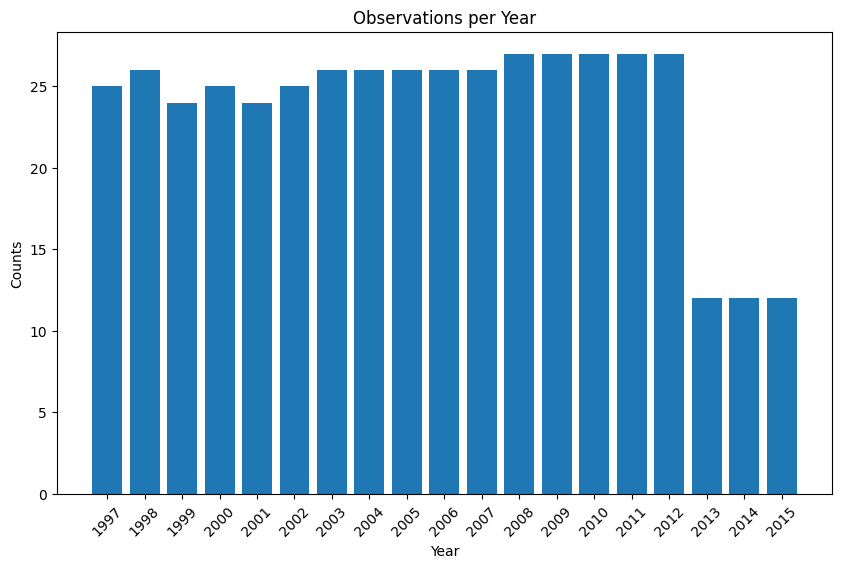

In [168]:
# Plot count per year on bar plot
plt.figure(figsize=(10, 6))
plt.bar(year_counts['year'], year_counts['counts'])
plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('Observations per Year')
plt.xticks(year_counts['year'], rotation=45)

plt.show()

In [171]:
# Keep only years from 1997 to 2012
df_merged = df_merged.set_index(["country_name", "year"])
df_merged.sort_index(inplace=True)
idx = pd.IndexSlice
df_merged = df_merged.loc[idx[:, 1997:2012], :]
df_merged.describe()

,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity
count,414.000000,414.000000,4.140000e+02,414.000000,414.000000,414.000000,414.000000,414.000000
mean,23.339508,1.758365,1.202335e+06,73.970127,7.714816,9.561744,1.824245,8.934783
std,11.387808,0.455432,4.510842e+06,36.653892,3.871536,2.053843,0.955162,3.376044
min,4.600000,1.130000,1.189215e+04,16.438585,0.817360,3.200000,0.375000,-7.000000
25%,12.195122,1.390000,2.971782e+04,50.241516,5.527845,8.343500,0.916667,9.000000
50%,21.948662,1.700500,4.007066e+04,63.909417,7.734887,10.077000,1.837500,10.000000
75%,33.375000,1.920000,1.292061e+05,88.406388,9.685877,11.160000,2.586458,10.000000
max,47.277937,3.514000,3.088083e+07,191.446681,18.454738,12.670000,4.133333,10.000000


In [172]:
# Count number of observations by country
country_counts = df_merged.groupby(['country_name']).size().reset_index(name='counts')
df_country_counts = country_counts.groupby('country_name')['counts'].sum().reset_index()
df_country_counts


,country_name,counts
0,Australia,15
1,Austria,14
2,Belgium,16
3,Brazil,16
4,Canada,15
5,China,15
6,Denmark,15
7,Finland,16
8,France,16
9,Germany,16


In [173]:
# Drop Slovenia, which is an outlier
df_merged = df_merged.reset_index()
df_merged = df_merged[df_merged['country_name'] != 'Slovenia']
country_counts = df_merged.groupby(['country_name']).size().reset_index(name='counts')
df_country_counts = country_counts.groupby('country_name')['counts'].sum().reset_index()
df_country_counts

,country_name,counts
0,Australia,15
1,Austria,14
2,Belgium,16
3,Brazil,16
4,Canada,15
5,China,15
6,Denmark,15
7,Finland,16
8,France,16
9,Germany,16


In [175]:
# Plot counts per country on world map
map_gps = px.choropleth(
    df_country_counts,                                 # dataframe as argument
    locations="country_name",                       # column name with location
    locationmode="country names",                          # Correct location method
    color="counts",                       # color countries with women_seats value
    color_continuous_scale=px.colors.sequential.Blues,   # choice of colors
    hover_name="country_name",  # Show country name on hover
    hover_data={"country_name": False, "counts": True},  # Hide redundant info in tooltip
    template="plotly_white"  # Cleaner template
)

map_gps.update_layout(
    title_text="Observations per Country",
    title_x=0.5,
    title_y=0.95,
    geo=dict(
        showframe=False,  # This removes the frame around the map
        projection_type='equirectangular',  # Projection style
        landcolor='lightgray',  # Set countries with no data to light gray
        countrycolor='darkgray'  # Optional: Set country borders to dark gray
    ),
    coloraxis_colorbar=dict(
        title="Count",  # Title for color bar
        tickvals=[df_country_counts['counts'].min(), df_country_counts['counts'].max()],  # Specific tick values
        tickformat=",.0f"  # Formatting for tick labels
    )
)

map_gps.show()

### 4.4) Overview of Merged Database

In [176]:
df_merged.describe()

,year,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity
count,409.000000,409.000000,409.000000,4.090000e+02,409.000000,409.000000,409.000000,409.000000,409.000000
mean,2004.579462,23.364034,1.760863,1.216804e+06,73.268032,7.714034,9.533702,1.820518,8.921760
std,4.609684,11.412746,0.457643,4.536483e+06,36.300494,3.894899,2.050524,0.959714,3.394595
min,1997.000000,4.600000,1.130000,1.189215e+04,16.438585,0.817360,3.200000,0.375000,-7.000000
25%,2001.000000,12.195122,1.390000,2.997511e+04,50.180013,5.506450,8.322000,0.916667,9.000000
50%,2005.000000,22.077922,1.710000,4.044055e+04,63.314330,7.753453,10.050000,1.829167,10.000000
75%,2009.000000,33.500000,1.926000,1.305855e+05,87.283871,9.729463,11.150000,2.591667,10.000000
max,2012.000000,47.277937,3.514000,3.088083e+07,191.446681,18.454738,12.670000,4.133333,10.000000


In [177]:
df_merged.head()

,country_name,year,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity
0,Australia,1997,15.540541,1.778,56708.836876,37.983357,16.706176,11.068,0.458333,10.0
1,Australia,1998,15.540541,1.762,58736.642006,39.994060,17.602334,11.052,0.770833,10.0
2,Australia,1999,22.448980,1.755,60977.083885,39.056113,17.737243,11.036,1.020833,10.0
3,Australia,2000,22.972973,1.756,62634.946751,40.966987,17.837318,11.020,0.979167,10.0
4,Australia,2002,25.333333,1.756,64875.884897,41.471680,18.123211,11.160,1.212500,10.0


In [178]:
# Reset index for easier download
#df_download = df_merged.reset_index()
from google.colab import files
file_path = "merged_data_final.xlsx"
df_merged.to_excel(file_path, index=True)
# Download the file to your local machine
#UNCOMMENT BELOW FOR DOWNLOAD
#files.download(file_path)

#Univariate Analyses 🔍

##<h3>Independent Variable: Women Seats in Parliaments</h3>

In [ ]:
df_merged['women_seats'].describe()

In [ ]:
# Calculating the statistical values
mean_value = df_merged['women_seats'].mean()
median_value = df_merged['women_seats'].median()
variance_value = df_merged['women_seats'].var()

# Plotting the boxplot with seaborn and adding annotations
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_merged['women_seats'], color="lightblue", width=0.3)
plt.title("Boxplot of the proportion of seats held by women in national parliaments")
plt.ylabel("Pourcentage of women seats")
plt.grid(axis='x')

# Annotating the statistical values on the graph
plt.annotate(f"Mean: {mean_value:.2f}", xy=(0.7, 0.9), xycoords="axes fraction", fontsize=12)
plt.annotate(f"Median: {median_value:.2f}", xy=(0.7, 0.85), xycoords="axes fraction", fontsize=12)
plt.annotate(f"Variance: {variance_value:.2f}", xy=(0.7, 0.8), xycoords="axes fraction", fontsize=12)

plt.show()

In [ ]:
# Defining the median for women_seats
mean_value = df_merged['women_seats'].mean()
median_value = df_merged['women_seats'].median()
variance_value = df_merged['women_seats'].var()
Q1 = df_merged['women_seats'].quantile(0.25)
Q3 = df_merged['women_seats'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = max(Q1 - 1.5 * IQR, 0)  # Adjusting lower whisker to 0% if negative
upper_whisker = Q3 + 1.5 * IQR

# Counting outliers
outliers_count = ((df_merged['women_seats'] < lower_whisker) |
                  (df_merged['women_seats'] > upper_whisker)).sum()

# Redrawing the boxplot for women_seats with detailed annotations
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_merged['women_seats'])
plt.title('Boxplot of Women Seats in National Parliaments')
plt.xlabel('Women Seats (%)')

# Annotating the mean, median, variance, quartiles, and whiskers
plt.axvline(x=mean_value, color='yellow', linestyle='--', label=f'Mean: {mean_value:.2f}%')
plt.axvline(x=median_value, color='green', linestyle='--', label=f'Median: {median_value:.2f}%')
plt.axvline(x=Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.2f}%')
plt.axvline(x=Q3, color='red', linestyle='--', label=f'Q3: {Q3:.2f}%')
plt.axvline(x=lower_whisker, color='purple', linestyle=':', label=f'Lower Whisker: {max(lower_whisker, 0):.2f}%')
plt.axvline(x=upper_whisker, color='orange', linestyle=':', label=f'Upper Whisker: {upper_whisker:.2f}%')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['women_seats'], bins=10, kde=True, color="dodgerblue")
plt.title("Distribution of Women Seats in National Parliaments")
plt.xlabel("Women Seats (%)")
plt.ylabel("Frequency")
plt.grid(axis='y')

# Compute skewness and display it on the graph
skewness_value = skew(df_merged['women_seats'], nan_policy='omit')
plt.annotate(f"Skewness: {skewness_value:.2f}", xy=(0.7, 0.9), xycoords="axes fraction", fontsize=12)

plt.show()

In [ ]:
# Grouping by country_name and computing the mean of women_seats
sample_df_map = df_merged.groupby(['country_name'])['women_seats'].mean().reset_index()

# Creating the interactive map using the aggregated data
sample_fig = px.choropleth(
    sample_df_map,
    locations='country_name',
    locationmode='country names',
    color='women_seats',
    hover_name='country_name',
    color_continuous_scale=px.colors.sequential.Blues
)
# Update layout to center the title
sample_fig.update_layout(
    title_text="Average Women Seats in National Parliaments by Country",
    title_x=0.5,  # Centering the title
    coloraxis_colorbar=dict(
        title="Avg Women Seats (%)"  # Name of the color bar
        #tickvals=[sample_df_map['women_seats'].min(), sample_df_map['women_seats'].max()]  # Specific tick values

    ),
    geo=dict(
        showframe=False,  # This removes the frame around the map
        projection_type='equirectangular',  # Projection style
        landcolor='lightgray',  # Set countries with no data to light gray
        countrycolor='darkgray'  # Optional: Set country borders to dark gray
    )
)
sample_fig.show()

In [ ]:
# Grouping by year and computing the mean of women_seats
mean_stringency_per_year = df_merged.groupby('year')['women_seats'].mean().reset_index()

# Creating the line graphs using plotly
fig1 = px.line(
    mean_stringency_per_year,
    x='year',
    y='women_seats',
    title="Average Women Seats in National Parliaments Over Time"
)
fig1.update_layout(width=800, height=400)
fig1.update_xaxes(title_text='Year')
fig1.update_yaxes(title_text='Women Seats (%)')


fig2 = px.line(
    df_merged,
    x='year',
    y='women_seats',
    color='country_name',
    title="Proportion of seats held by women in national parliaments over time by country"
)
fig1.show()
fig2.show()

## <h3>Dependent Variable: Environmental Policies Stringency Index</h3>

In [ ]:
#describe the varaiable

df_merged['stringency_index'].describe()

In [ ]:
# Calculating the statistical values
mean_value = df_merged['stringency_index'].mean()
median_value = df_merged['stringency_index'].median()
variance_value = df_merged['stringency_index'].var()

# Plotting the boxplot with seaborn and adding annotations
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_merged['stringency_index'], color="lightblue", width=0.3)
plt.title("Boxplot of Stringency Index")
plt.ylabel("Stringency Index")
plt.grid(axis='x')

# Annotating the statistical values on the graph
plt.annotate(f"Mean: {mean_value:.2f}", xy=(0.7, 0.9), xycoords="axes fraction", fontsize=12)
plt.annotate(f"Median: {median_value:.2f}", xy=(0.7, 0.85), xycoords="axes fraction", fontsize=12)
plt.annotate(f"Variance: {variance_value:.2f}", xy=(0.7, 0.8), xycoords="axes fraction", fontsize=12)

plt.show()


In [ ]:
# Defining the median for women_seats
mean_value = df_merged['stringency_index'].mean()
median_value = df_merged['stringency_index'].median()
variance_value = df_merged['stringency_index'].var()
Q1 = df_merged['stringency_index'].quantile(0.25)
Q3 = df_merged['stringency_index'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = max(Q1 - 1.5 * IQR, 0)  # Adjusting lower whisker to 0% if negative
upper_whisker = Q3 + 1.5 * IQR

# Counting outliers
outliers_count = ((df_merged['stringency_index'] < lower_whisker) |
                  (df_merged['stringency_index'] > upper_whisker)).sum()

# Redrawing the boxplot for women_seats with detailed annotations
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_merged['stringency_index'])
plt.title('Boxplot of Environmental Policy Stringency Index')
plt.xlabel('Environmental Policy Stringency Index')

# Annotating the mean, median, variance, quartiles, and whiskers
plt.axvline(x=mean_value, color='yellow', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(x=median_value, color='green', linestyle='--', label=f'Median: {median_value:.2f}')
plt.axvline(x=Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.2f}')
plt.axvline(x=Q3, color='red', linestyle='--', label=f'Q3: {Q3:.2f}')
plt.axvline(x=lower_whisker, color='purple', linestyle=':', label=f'Lower Whisker: {max(lower_whisker, 0):.2f}')
plt.axvline(x=upper_whisker, color='orange', linestyle=':', label=f'Upper Whisker: {upper_whisker:.2f}')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['stringency_index'], bins=10, kde=True, color="dodgerblue")
plt.title("Distribution of Environmental Policy Stringency Index")
plt.xlabel("Environmental Policy Stringency Index")
plt.ylabel("Frequency")
plt.grid(axis='y')

# Compute skewness and display it on the graph
skewness_value = skew(df_merged['stringency_index'], nan_policy='omit')
plt.annotate(f"Skewness: {skewness_value:.2f}", xy=(0.7, 0.9), xycoords="axes fraction", fontsize=12)

plt.show()

In [ ]:
# Grouping by country_name and computing the mean of stringency_index
sample_df_map = df_merged.groupby(['country_name'])['stringency_index'].mean().reset_index()

# Creating the interactive map using the aggregated data
sample_fig = px.choropleth(
    sample_df_map,
    locations='country_name',
    locationmode='country names',
    color='stringency_index',
    hover_name='country_name',
    color_continuous_scale=px.colors.sequential.Blues,
)
# Update layout to center the title
sample_fig.update_layout(
    title_text="Average Environmental Policy Stringency Index by Country",
    title_x=0.5,  # Centering the title
    coloraxis_colorbar=dict(
        title="Avg Environmental<br>Policy Stringency<br>Index"  # Name of the color bar
        #tickvals=[sample_df_map['women_seats'].min(), sample_df_map['women_seats'].max()]  # Specific tick values

    ),
    geo=dict(
        showframe=False,  # This removes the frame around the map
        projection_type='equirectangular',  # Projection style
        landcolor='lightgray',  # Set countries with no data to light gray
        countrycolor='darkgray'  # Optional: Set country borders to dark gray
    )
)
sample_fig.show()
#Viridis,Cividis,Inferno,Magma,Jet, YlGnBu ,RdYlBu

In [ ]:
# Grouping by year and computing the mean of stringency_index
mean_stringency_per_year = df_merged.groupby('year')['stringency_index'].mean().reset_index()

# Creating the line graphs using plotly
fig1 = px.line(
    mean_stringency_per_year,
    x='year',
    y='stringency_index',
    title="Average Environmental Policy Stringency Index Over Time"
)
fig1.update_layout(width=800, height=400)
fig1.update_xaxes(title_text='Year')
fig1.update_yaxes(title_text='Environmental Policy Stringency Index')

fig2 = px.line(
    df_merged,
    x='year',
    y='stringency_index',
    color='country_name',
    title="Stringency Index Over Time by Country"
)
fig1.show()
fig2.show()

## <h3>Heterogeneity Variable: Fertility Rate</h3>

In [ ]:
df_merged['fertility_rate'].describe()

In [ ]:
# Calculating the statistical values
mean_value = df_merged['fertility_rate'].mean()
median_value = df_merged['fertility_rate'].median()
variance_value = df_merged['fertility_rate'].var()

# Plotting the boxplot with seaborn and adding annotations
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_merged['fertility_rate'], color="lightblue", width=0.3)
plt.title("Boxplot of fertility rate")
plt.ylabel("fertility rate")
plt.grid(axis='x')

# Annotating the statistical values on the graph
plt.annotate(f"Mean: {mean_value:.2f}", xy=(0.7, 0.9), xycoords="axes fraction", fontsize=12)
plt.annotate(f"Median: {median_value:.2f}", xy=(0.7, 0.85), xycoords="axes fraction", fontsize=12)
plt.annotate(f"Variance: {variance_value:.2f}", xy=(0.7, 0.8), xycoords="axes fraction", fontsize=12)

plt.show()


In [ ]:
# Defining the median for women_seats
mean_value = df_merged['fertility_rate'].mean()
median_value = df_merged['fertility_rate'].median()
variance_value = df_merged['fertility_rate'].var()
Q1 = df_merged['fertility_rate'].quantile(0.25)
Q3 = df_merged['fertility_rate'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = max(Q1 - 1.5 * IQR, 0)  # Adjusting lower whisker to 0% if negative
upper_whisker = Q3 + 1.5 * IQR

# Counting outliers
outliers_count = ((df_merged['fertility_rate'] < lower_whisker) |
                  (df_merged['fertility_rate'] > upper_whisker)).sum()

# Redrawing the boxplot for women_seats with detailed annotations
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_merged['fertility_rate'])
plt.title('Boxplot of Fertility Rate')
plt.xlabel('Fertility Rate')

# Annotating the mean, median, variance, quartiles, and whiskers
plt.axvline(x=mean_value, color='yellow', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(x=median_value, color='green', linestyle='--', label=f'Median: {median_value:.2f}')
plt.axvline(x=Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.2f}')
plt.axvline(x=Q3, color='red', linestyle='--', label=f'Q3: {Q3:.2f}')
plt.axvline(x=lower_whisker, color='purple', linestyle=':', label=f'Lower Whisker: {max(lower_whisker, 0):.2f}')
plt.axvline(x=upper_whisker, color='orange', linestyle=':', label=f'Upper Whisker: {upper_whisker:.2f}')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['fertility_rate'], bins=10, kde=True, color="dodgerblue")
plt.title("Distribution of Fertility Rate")
plt.xlabel("Fertility Rate")
plt.ylabel("Frequency")
plt.grid(axis='y')

# Compute skewness and display it on the graph
skewness_value = skew(df_merged['fertility_rate'], nan_policy='omit')
plt.annotate(f"Skewness: {skewness_value:.2f}", xy=(0.7, 0.9), xycoords="axes fraction", fontsize=12)

plt.show()

In [ ]:
# Grouping by country_name and computing the mean of fertility_rate
sample_df_map = df_merged.groupby(['country_name'])['fertility_rate'].mean().reset_index()

# Creating the interactive map using the aggregated data
sample_fig = px.choropleth(
    sample_df_map,
    locations='country_name',
    locationmode='country names',
    color='fertility_rate',
    hover_name='country_name',
    color_continuous_scale=px.colors.sequential.Blues
    )

# Update layout to center the title
sample_fig.update_layout(
    title_text="Average Fertility Rate by Country",
    title_x=0.5,  # Centering the title
    coloraxis_colorbar=dict(
        title="Avg Fertility Rate"  # Name of the color bar
        #tickvals=[sample_df_map['women_seats'].min(), sample_df_map['women_seats'].max()]  # Specific tick values

    ),
    geo=dict(
        showframe=False,  # This removes the frame around the map
        projection_type='equirectangular',  # Projection style
        landcolor='lightgray',  # Set countries with no data to light gray
        countrycolor='darkgray'  # Optional: Set country borders to dark gray
    )
)
sample_fig.show()
#Viridis,Cividis,Inferno,Magma,Jet, YlGnBu ,RdYlBu

In [ ]:
# Grouping by year and computing the mean of stringency_index
mean_stringency_per_year = df_merged.groupby('year')['fertility_rate'].mean().reset_index()

# Creating the line graphs using plotly
fig1 = px.line(
    mean_stringency_per_year,
    x='year',
    y='fertility_rate',
    title="Average fertility rate Over Time"
)
fig1.update_layout(width=800, height=400)
fig1.update_xaxes(title_text='Year')
fig1.update_yaxes(title_text='Fertility Rate')

fig2 = px.line(
    df_merged,
    x='year',
    y='fertility_rate',
    color='country_name',
    title="Fertility rate Over Time by Country"
)
fig1.show()
fig2.show()

#Bivariate Analysis 🖇



## <h3>Correlation</h3>

We can start by checking the correlation between the proportion of women and the ennvironmental index

In [ ]:
women_index_corr = df_merged.loc[:,'stringency_index':'women_seats'].corr()
women_index_corr

## <h3>Heat map</h3>

Let's now do a heat map to have a more visual representation

In [ ]:
heatmap_corr = px.imshow(
    women_index_corr.values.round(2),         # correlation matrix values, rounded at 2 decimals
    x=list(women_index_corr.columns),         # label x-axis
    y=list(women_index_corr.index),           # label y-axis
    text_auto=True,                   # add values to the graph
    aspect="auto"                     # automatically adjust aspect (without the option: square)
)
heatmap_corr.update_xaxes(side="top")   # display labels on top (by default: bottom)
heatmap_corr.show()

## <h3>Scatter plot</h3>

In [ ]:
sns.regplot(x='stringency_index',
            y='women_seats',
            data=df_merged,
            scatter_kws={'color': 'black'},  # Paramètres du scatter plot
            line_kws={'color': 'blue'}        # Paramètres de la ligne de régression
           )

plt.title("Scatter plot of percentage of women seat in national parlements and stringency index")
plt.xlabel("Stringency index")
plt.ylabel("%Women seats")
plt.show()


In [ ]:
lm = sns.lmplot(
    x='stringency_index',
    y='women_seats',
    data=df_merged,
    hue='country_name',            # Coloring by country
    scatter_kws={'color': 'black'},  # Overriding this to keep dots black, but they'll be colored by hue
    line_kws={'color': 'blue'},      # Regression line color
    height=6,
    aspect=1.5
)

lm.set_axis_labels("Stringency index", "Women seats")
lm.fig.suptitle("Scatter plot of women seat and stringency index", y=1.03)

plt.show()

In [ ]:
#Scatter plot coloring the dots by fertility rate
scatter=sns.scatterplot(x='stringency_index', y='women_seats', legend=True, hue='fertility_rate', palette='plasma', data=df_merged)
sns.regplot(x='stringency_index',
            y='women_seats',
            data=df_merged,
            scatter=False,           # We don't want to plot points again
            color='blue')
plt.title("Scatter plot with coloring based on fertility rate")
plt.xlabel('Stringency_index')
plt.ylabel('% Women seats')

In [ ]:
#Scatter plot with coloring based on country
scatter=sns.scatterplot(x='stringency_index', y='women_seats', legend=False, hue='country_name', palette='Set2', data=df_merged)
sns.regplot(x='stringency_index',
            y='women_seats',
            data=df_merged,
            scatter=False,           # We don't want to plot points again
            color='blue')

plt.xlabel('Stringency_index')
plt.ylabel('Women seats')

In [ ]:
# Calculate the median of fertility_rate
fertility_median = df_merged['fertility_rate'].median()

# Create a new column to indicate if fertility_rate is above or below the median
df_merged['fertility_group'] = ['Above Median' if x > fertility_median else 'Below Median'
                                               for x in df_merged['fertility_rate']]

# Plot the scatter plot with two regression lines using lmplot
lm = sns.lmplot(x='stringency_index',
                y='women_seats',
                hue='fertility_group',
                data=df_merged,
                height=6,
                aspect=1.5)

lm.set_axis_labels("Stringency index ", "Percentage of Women seats in national parlement")
lm.fig.suptitle("Relationship between Stringency index and percentage of women seats in national parlement by fertility rate group", y=1.03)

plt.show()

In [ ]:
# Filter the DataFrame for entries below the median and calculate the correlation
below_median_corr = df_merged[df_merged['fertility_group'] == 'Below Median']\
                        [['stringency_index', 'women_seats']].corr().iloc[0, 1]

# Filter the DataFrame for entries above the median and calculate the correlation
above_median_corr = df_merged[df_merged['fertility_group'] == 'Above Median']\
                        [['stringency_index', 'women_seats']].corr().iloc[0, 1]

below_median_corr, above_median_corr

In [ ]:
# Create a DataFrame with correlation values
corr_data = pd.DataFrame({
    'Below Median': [below_median_corr],
    'Above Median': [above_median_corr]
}, index=['Correlation'])

# Display the heatmap using Seaborn
plt.figure(figsize=(3, 2))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation between stringency_index and women_seats")
plt.show()

## <h3>Pair Plot</h3>

In [ ]:
#sns.pairplot(df_merged.loc[:,'stringency_index':'women_seats'])      # dataframe as argument

#Linear Simple Regression Model

##Step 1 selection of the columns ##

In [ ]:
# Sélection des colonnes pour la régression
X = df_merged[['women_seats']]  # X variable independante
y = df_merged['stringency_index']  # y variable dependante

##Step 2 Division des données en ensembles d'entraînement et de test##

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Step 3: Création et Entraînement du Modèle##

In [ ]:
# Création de l'objet régression linéaire
model = LinearRegression()

# Entraînement du modèle avec les données d'entraînement
model.fit(X_train, y_train)


##Step 4: Prédiction et Évaluation du Modèle##

In [ ]:
# Prédiction avec les données de test
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R^2 score: {r2}")


Le MSE (Mean Squared Error) vous donne une idée de l'erreur moyenne du modèle.
Le R^2 score indique la proportion de la variance de la variable dépendante qui est prévisible à partir des variables indépendantes. Une valeur proche de 1 indique un bon ajustement.

In [ ]:
# Tracer les points de données
plt.scatter(X_test, y_test, color='blue', label='Données réelles')

# Tracer la ligne de régression
plt.plot(X_test, y_pred, color='red', label='Ligne de régression')

# Titres et légendes
plt.title('Régression Linéaire entre Women Seats et Stringency Index')
plt.xlabel('Women Seats')
plt.ylabel('Stringency Index')
plt.legend()

# Afficher le graphique
plt.show()

In [ ]:
X = df_merged[['women_seats']]
X = sm.add_constant(X)  # Ajoute une colonne constante pour l'intercept
model = sm.OLS(y, X).fit()
print(model.summary())

# Linear Multiple Regression Model (gdp)

In [ ]:
# Sélection des colonnes pour la régression
X = df_merged[['women_seats', 'gdp']]  # Inclure GDP comme variable de contrôle
y = df_merged['stringency_index']

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

# Tracer les données réelles vs. prédictions (pour women_seats seulement pour la simplicité de visualisation)
plt.scatter(X_test['women_seats'], y_test, color='blue', label='Données réelles')
plt.scatter(X_test['women_seats'], y_pred, color='red', label='Prédictions', alpha=0.5)

# Titres et légendes
plt.title('Régression Linéaire avec Women Seats et GDP comme prédicteurs de Stringency Index')
plt.xlabel('Women Seats')
plt.ylabel('Stringency Index')
plt.legend()

# Afficher le graphique
plt.show()

In [ ]:
X = df_merged[['women_seats', 'gdp']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

##Analyse de Multicollinéarité ##

In [ ]:
# Ajouter une colonne constante pour l'intercept
X = df_merged[['women_seats', 'gdp']]
X = add_constant(X)

# Calcul du VIF pour chaque variable indépendante
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

Dans ce code, variance_inflation_factor est utilisé pour calculer le VIF pour chaque variable indépendante. Un VIF supérieur à 5 (ou parfois 10, selon les normes du domaine) indique une multicollinéarité potentiellement problématique.

Interprétation VIF : Des valeurs élevées de VIF indiquent que la variable en question est fortement linéairement corrélée avec d'autres variables indépendantes dans le modèle, ce qui peut fausser les coefficients de régression et leurs interprétations.

const (5.802625) : Cette valeur correspond à l'intercept de votre modèle. Le VIF de l'intercept n'est généralement pas interprété de la même manière que pour les autres variables, car il représente simplement la constante ajoutée au modèle et non une variable indépendante.

women_seats (1.059288) : Un VIF de 1.059288 pour women_seats est très bas. En règle générale, un VIF inférieur à 5 (ou même 10 dans certains cas) indique qu'il n'y a pas de problème de multicollinéarité significatif. Cela signifie que women_seats n'est pas fortement corrélé avec les autres variables indépendantes dans le modèle.

gdp (1.059288) : De même, un VIF de 1.059288 pour gdp indique également l'absence de multicollinéarité problématique. Cela suggère que gdp est indépendant des autres variables indépendantes dans le modèle, du moins en termes de corrélation linéaire.

In [ ]:
X = df_merged[['women_seats', 'gdp']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

#Difference in Difference

##<h3>Data QoG Gender Quotas</h3>

In [ ]:
# Import data from Quota Adoption and Reform over Time Dataset
url = "https://raw.githubusercontent.com/vgentile98/zebraproject/main/data/qogdata_18_12_2023.xlsx"
df_qog_quota = pd.read_excel(url)

# Keep only relevant columns
columns_to_keep = ["cname", "year", "qar_efqu"]
df_qog_quota = df_qog_quota[columns_to_keep]
df_qog_quota.rename(columns={'cname': 'country_name', 'qar_efqu': 'quota'}, inplace=True)


df_qog_quota

In [ ]:
df_merged = df_merged.drop(columns=['quota'], errors='ignore')  # drops quota column from df_merged if it exists
df_merged = pd.merge(df_merged, df_qog_quota, on=['country_name', 'year'], how='inner')
df_merged

##<h3>Stringency Index Patterns



Erreurs Standard et Intervalle de Confiance : Si vous trouvez que les erreurs standard des coefficients sont très grandes ou que les intervalles de confiance sont anormalement larges, cela peut également indiquer une multicollinéarité.

In [ ]:
# Plotting stringency index over time for all countries with vertical lines for quota implementation

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(10, 10))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

df_merged.set_index(['country_name', 'year'], inplace=True)

highlighted_countries = ['Denmark', 'Finland', 'India', 'Japan']

plot_stringency_index(df_merged, highlighted_countries)

In [ ]:
# Plotting stringency index over time for countries that has a quota implementation between 1997-2012

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(12, 12))
    countries_with_quota = set()  # Set to store countries with quota implementation
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])  # Color cycle

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Check for quota implementation
            prev_val = 0
            for year, row in valid_data.iterrows():
                if row['quota'] == 1 and prev_val == 0:
                    countries_with_quota.add(country)
                    break  # Stop after finding the first instance of quota implementation
                prev_val = row['quota']

    # Plot only for highlighted countries and countries with quota implementation
    for country in df.index.get_level_values(0).unique():
        if country in highlighted_countries or country in countries_with_quota:
            country_data = df.xs(country, level="country_name")
            valid_data = country_data.dropna(subset=['stringency_index'])
            if not valid_data.empty:
                line_width = 2.5 if country in highlighted_countries else 1
                country_color = next(color_cycle)  # Get a color from the cycle
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=line_width, color=country_color)

                # Annotate the last point with the country name
                plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

                # Add vertical lines for quota implementations
                prev_val = 0
                for year, row in valid_data.iterrows():
                    if row['quota'] == 1 and prev_val == 0:
                        plt.axvline(x=year, color=country_color, linestyle='--', alpha=0.7)
                        if country not in highlighted_countries:  # Annotate non-highlighted countries
                            plt.text(year, plt.gca().get_ylim()[1], country, rotation=90, color=country_color, fontsize=8, ha='right')
                    prev_val = row['quota']

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

df_merged.set_index(['country_name', 'year'], inplace=True)

highlighted_countries = ['Denmark', 'Finland', 'India', 'Japan']

plot_stringency_index(df_merged, highlighted_countries)

In [ ]:
# Plotting stringency index over time for Germany and Ireland

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

selected_countries = ['Germany', 'Ireland']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_stringency_index(filtered_df, highlighted_countries)

In [ ]:
# Plotting stringency index over time for France and Netherlands

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

selected_countries = ['France','Netherlands']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_stringency_index(filtered_df, highlighted_countries)

In [ ]:
# Plotting stringency index over time for France and Japan

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

selected_countries = ['France','Japan']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_stringency_index(filtered_df, highlighted_countries)

In [ ]:
# Plotting stringency index over time for Denmark and Australia

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

selected_countries = ['Denmark','Australia']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_stringency_index(filtered_df, highlighted_countries)

In [ ]:
# Plotting stringency index over time for India and Indonesia

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

selected_countries = ['India','Indonesia']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_stringency_index(filtered_df, highlighted_countries)

In [ ]:
# Plotting stringency index over time for Canada and Portugal

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

selected_countries = ['Canada','Portugal']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_stringency_index(filtered_df, highlighted_countries)

In [ ]:
# Plotting stringency index over time for Spain and Portugal

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

selected_countries = ['Spain','Portugal']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_stringency_index(filtered_df, highlighted_countries)

In [ ]:
# Plotting stringency index over time for Finland and Norway

def plot_stringency_index(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'stringency_index' data
        valid_data = country_data.dropna(subset=['stringency_index'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['stringency_index'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['stringency_index'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Stringency Index')
    plt.title('Stringency Index Over Time by Country')
    plt.show()

selected_countries = ['Finland', 'Norway']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_stringency_index(filtered_df, highlighted_countries)

# Archives

## <h3>3) Chapel Hill Expert Survey (CHES)</h3>
Calculating the <b>left orientation index of parliaments</b>.

In [219]:
# Import data from Chapel Hill Expert Survey Dataset
url = "https://raw.githubusercontent.com/vgentile98/zebraproject/main/data/CHES_TREND_1999-2019.xlsx"
df_ches=pd.read_excel(url)

# Keep only relevant columns
columns_to_keep = ["country", "year", "party", "seat", "lrgen"]
df_ches = df_ches[columns_to_keep]

df_ches

,country,year,party,seat,lrgen
0,1,1999,PS,12.700000,3.111111
1,1,2002,PS,12.700000,3.350000
2,1,2006,PS,16.700001,3.500000
3,1,2010,PS,17.299999,2.500000
4,1,2014,PS,15.300000,2.600000
...,...,...,...,...,...
1191,40,2014,KOP,1.800000,5.250000
1192,40,2019,KOP,3.600000,4.500000
1193,40,2019,SYM,5.400000,4.500000
1194,40,2019,KINHMA,5.400000,7.000000


In [220]:
# Create a dictionary to map country IDs to names
id_to_name = {
    1: 'Belgium', 2: 'Denmark', 3: 'Germany', 4: 'Greece', 5: 'Spain',
    6: 'France', 7: 'Ireland', 8: 'Italy', 10: 'Netherlands', 11: 'United Kingdom',
    12: 'Portugal', 13: 'Austria', 14: 'Finland', 16: 'Sweden',
    20: 'Bulgaria', 21: 'Czech Republic', 22: 'Estonia', 23: 'Hungary', 24: 'Latvia',
    25: 'Lithuania', 26: 'Poland', 27: 'Romania', 28: 'Slovakia', 29: 'Slovenia',
    31: 'Croatia', 37: 'Malta', 38: 'Luxembourg', 40: 'Cyprus'
}

# Replace the "country" column values with country names
df_ches['country'] = df_ches['country'].map(id_to_name)

df_ches

,country,year,party,seat,lrgen
0,Belgium,1999,PS,12.700000,3.111111
1,Belgium,2002,PS,12.700000,3.350000
2,Belgium,2006,PS,16.700001,3.500000
3,Belgium,2010,PS,17.299999,2.500000
4,Belgium,2014,PS,15.300000,2.600000
...,...,...,...,...,...
1191,Cyprus,2014,KOP,1.800000,5.250000
1192,Cyprus,2019,KOP,3.600000,4.500000
1193,Cyprus,2019,SYM,5.400000,4.500000
1194,Cyprus,2019,KINHMA,5.400000,7.000000


In [221]:
# Calculate weighted ideology for each party
df_ches['weighted_ideology'] = df_ches['lrgen'] * df_ches['seat']

# Group by country and year, and sum the weighted ideologies
df_ches_grouped = df_ches.groupby(['country', 'year']).apply(
    lambda x: pd.Series({
        'total_weighted_ideology': (x['weighted_ideology'].sum() / x['seat'].sum())
    })
).reset_index()

# Rename columns
df_ches_grouped.rename(columns={'country': 'country_name'}, inplace=True)

# Display the dataframe
df_ches_grouped

# Calculate parliament ideology per country and per year (ideology of the parliament based on a weighted party average)
#df_ches['weighted_ideology'] = (df_ches['lrgen'] * df_ches['seat']).groupby([df_ches['country'], df_ches['year']]).transform('sum') / df_ches.groupby([df_ches['country'], df_ches['year']])['seat'].transform('sum')

# Select & rename columns
#df_ches = df_ches[['country', 'year', 'weighted_ideology']]
#df_ches.rename(columns={'country': 'country_name'}, inplace=True)

#df_ches

,country_name,year,total_weighted_ideology
0,Austria,1999,5.647700
1,Austria,2002,5.546680
2,Austria,2006,5.476024
3,Austria,2010,5.879714
4,Austria,2014,5.723600
...,...,...,...
136,United Kingdom,2002,5.698887
137,United Kingdom,2006,5.340341
138,United Kingdom,2010,5.596094
139,United Kingdom,2014,5.340442


In [222]:
# Ensure 'year' is type int
df_ches_grouped['year'] = df_ches_grouped['year'].astype(int)

# Interpolation for each country
all_years = np.arange(1999, 2020)  # De 1999 à 2019 inclus
interpolated_data = []

for country in df_ches_grouped['country_name'].unique():
    country_df = df_ches_grouped[df_ches_grouped['country_name'] == country]
    country_df = country_df.set_index('year').reindex(all_years).reset_index()
    country_df['country_name'] = country
    country_df['total_weighted_ideology'] = country_df['total_weighted_ideology'].interpolate()
    interpolated_data.append(country_df)

interpolated_df = pd.concat(interpolated_data)

print(interpolated_df)

    year    country_name  total_weighted_ideology
0   1999         Austria                 5.647700
1   2000         Austria                 5.614027
2   2001         Austria                 5.580353
3   2002         Austria                 5.546680
4   2003         Austria                 5.529016
..   ...             ...                      ...
16  2015  United Kingdom                 5.291886
17  2016  United Kingdom                 5.243330
18  2017  United Kingdom                 5.194775
19  2018  United Kingdom                 5.146219
20  2019  United Kingdom                 5.097663

[588 rows x 3 columns]


In [223]:
# Grouping by country_name and computing the mean of total_weighted_ideology
sample_df_map = interpolated_df.groupby(['country_name'])['total_weighted_ideology'].mean().reset_index()

# Creating the interactive map using the aggregated data
sample_fig = px.choropleth(
    sample_df_map,
    locations='country_name',
    locationmode='country names',
    color='total_weighted_ideology',
    hover_name='country_name',
    color_continuous_scale=px.colors.sequential.Blues
)
# Update layout to center the title
sample_fig.update_layout(
    title_text="Average total weighted ideology in National Parliaments by Country",
    title_x=0.5,  # Centering the title
    coloraxis_colorbar=dict(
        title="Avg total_weighted_ideology"  # Name of the color bar
        #tickvals=[sample_df_map['women_seats'].min(), sample_df_map['women_seats'].max()]  # Specific tick values

    ),
    geo=dict(
        showframe=False,  # This removes the frame around the map
        projection_type='equirectangular',  # Projection style
        landcolor='lightgray',  # Set countries with no data to light gray
        countrycolor='darkgray'  # Optional: Set country borders to dark gray
    )
)
sample_fig.show()

##<h3>Women in Parliament Patterns (OUTDATED)

In [ ]:
# Plotting women seats over time for all countries

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(12, 12))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()

df_merged.set_index(['country_name', 'year'], inplace=True)

highlighted_countries = ['Denmark', 'Finland', 'India', 'Japan']

plot_women_seats(df_merged, highlighted_countries)

In [ ]:
# Plotting women seats over time for Germany and Ireland

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Germany', 'Ireland']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)


In [ ]:
# Plotting women seats over time for Netherlands and France

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Netherlands', 'France']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

In [ ]:
# Plotting women seats over time for Denmark and Australia

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Denmark', 'Australia']
filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

In [ ]:
# Plotting women seats over time for Indonesia and India

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['India', 'Indonesia']
filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

In [ ]:
# Plotting women seats over time for Canada and Portugal

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Canada', 'Portugal']
filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

In [ ]:
# Plotting women seats over time for Spain and Portugal

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Spain', 'Portugal']
filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)